# Week 5

In [1]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)
import json
import re


# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna
import scipy.stats as stats
from scipy import sparse
from scipy.stats import loguniform, randint, uniform
from scipy.special import expit, logit


# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC

import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import get_scorer, ConfusionMatrixDisplay

from sklearn import clone
from sklearn.model_selection import ParameterSampler


# =============================
# Global
# =============================
random_state = 42
N_ROWS = 5_000_000  # sample size for all datasets
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(steam, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    n = len(steam)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return steam.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = steam.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(steam, y, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    y_arr = steam[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(steam)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return steam.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(steam, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = steam.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Memory Optimizer
# =============================
def optimize_dtypes(df, convert_categoricals=True, category_threshold=0.5):
    if df is None:
        return None

    start_bytes = int(df.memory_usage(deep=True).sum())

    # Downcast floats to float32
    for col in df.select_dtypes(include=["float"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="float")  # usually -> float32

    # Downcast integers to the smallest safe int type
    for col in df.select_dtypes(include=["integer", "int", "uint"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")  # int64 -> int32/16/8

    end_bytes = int(df.memory_usage(deep=True).sum())
    print({
        "memory_before_mb": round(start_bytes / (1024**2), 2),
        "memory_after_mb": round(end_bytes / (1024**2), 2),
        "saved_mb": round((start_bytes - end_bytes) / (1024**2), 2)
    })
    return df


# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # sample recommendations
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

    # sample Olist
    olist = simple_random_sample(olist, n_rows=N_ROWS, random_state=random_state)
    print("olist sample:", olist.shape)

# Run immediately after loading/creating `olist`
base_cols = [
    "order_id","customer_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_zip_code_prefix","customer_city",
    "customer_state","geolocation_lat","geolocation_lng","geo_points",
    "order_item_id","product_id","seller_id","shipping_limit_date","price",
    "freight_value","product_category_name","product_name_lenght",
    "product_description_lenght","product_photos_qty","product_weight_g",
    "product_length_cm","product_height_cm","product_width_cm",
    "product_category_name_english","seller_zip_code_prefix","seller_city",
    "seller_state","payment_value_total","payment_installments_max",
    "payment_count","review_score_mean","review_count"
]

idx_map = {}
cols_set = set(olist.columns)
for i, name in enumerate(base_cols):
    if i in cols_set:
        idx_map[i] = name
    if str(i) in cols_set:
        idx_map[str(i)] = name

olist = olist.rename(columns=idx_map)


# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)

    # sample VG2019
    if "Genre" in sales.columns:
        sales = stratified_sample(sales, y="Genre", n_rows=N_ROWS, random_state=random_state)
    else:
        sales = simple_random_sample(sales, n_rows=N_ROWS, random_state=random_state)
    print("sales sample:", sales.shape)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")

# Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos=None):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

pd.set_option("display.float_format", lambda x: f"{x:.6f}")


# =============================
# Final summaries (with downcasting)
# =============================
if steam is not None:
    print("\nOptimizing dtypes for steam...")
    steam = optimize_dtypes(steam, convert_categoricals=True)

if olist is not None:
    print("\nOptimizing dtypes for olist...")
    olist = optimize_dtypes(olist, convert_categoricals=True)

if sales is not None:
    print("\nOptimizing dtypes for sales...")
    sales = optimize_dtypes(sales, convert_categoricals=True)

print("\nsteam sample:", None if steam is None else steam.shape)
print("olist sample:", None if olist is None else olist.shape)
print("sales sample:", None if sales is None else sales.shape)


Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 5000000, 'frac': 0.12149252891412844, 'elapsed_sec': 5.989, 'mode': 'stratified'}
steam: (5000000, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441

In [2]:
def prepare_all(
    steam, olist, sales,
    top_k_tags=150, max_total_features=400,
    test_size=0.2, random_state=42,
    balance_method="auto",        # "auto", "oversample", "undersample", "none"
    min_class_ratio=0.7,          # balance if minority/majority < this
    feature_select_method="none", # "none", "mi", "rf"
    feature_select_k=200          # number of features to keep when selection is on
):
    # local imports needed for feature selection
    from sklearn.feature_selection import SelectKBest, mutual_info_classif
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import CountVectorizer

    # ---------- Steam ----------
    df = steam.copy()
    X = df.copy()

    needed_cols = [
        "date", "date_release", "title", "description", "price_final", "price_original", "tags",
        "win", "mac", "linux", "steam_deck",
        "helpful", "funny", "hours", "user_reviews", "products", "reviews"
    ]
    for c in needed_cols:
        if c not in X.columns:
            X[c] = np.nan

    # Dates
    X["date"] = pd.to_datetime(X["date"], errors="coerce")
    X["date_release"] = pd.to_datetime(X["date_release"], errors="coerce")
    X["days_since_release"] = (X["date"] - X["date_release"]).dt.days.clip(lower=0).fillna(0)
    X["review_year"] = X["date"].dt.year.fillna(0)
    X["review_month"] = X["date"].dt.month.fillna(0)
    X["review_dow"] = X["date"].dt.dayofweek.fillna(0)

    # Text lengths
    X["title_len"] = X["title"].fillna("").astype(str).str.len()
    X["desc_len"] = X["description"].fillna("").astype(str).str.len()

    # Log transforms
    for col in ["helpful", "funny", "hours", "user_reviews", "products", "reviews", "price_final", "price_original"]:
        X[col] = pd.to_numeric(X[col], errors="coerce")
        X[col + "_log1p"] = np.log1p(X[col])

    # Prices
    X["is_free"] = X["price_final"].eq(0).astype("int8")
    with np.errstate(divide="ignore", invalid="ignore"):
        X["discount_ratio"] = np.where(
            X["price_original"] > 0,
            1.0 - (X["price_final"] / X["price_original"]),
            0.0
        )
    X["discount_ratio"] = pd.Series(X["discount_ratio"]).clip(0, 1).fillna(0.0)

    # Platform flags
    for b in ["win", "mac", "linux", "steam_deck"]:
        if b not in X.columns:
            X[b] = 0
        X[b] = (X[b] == True).astype("int8")

    keep_dense = [
        "win", "mac", "linux", "steam_deck",
        "days_since_release", "review_year", "review_month", "review_dow",
        "title_len", "desc_len",
        "helpful_log1p", "funny_log1p", "hours_log1p",
        "user_reviews_log1p", "products_log1p", "reviews_log1p",
        "price_final_log1p", "price_original_log1p",
        "discount_ratio", "is_free"
    ]
    for c in keep_dense:
        if c not in X.columns:
            X[c] = np.nan

    steam_df = X[keep_dense].copy()
    steam_df = steam_df.fillna(steam_df.median(numeric_only=True))

    # Tags
    base_cols = steam_df.shape[1]
    allowed_tag_cols = max(0, min(top_k_tags, max_total_features - base_cols))
    if allowed_tag_cols > 0:
        tags_clean = (
            df["tags"].fillna("").astype(str).str.lower()
            .str.replace(r"[\[\]\"]", "", regex=True)
            .str.replace(";", ",").str.replace("/", ",")
        )
        vec = CountVectorizer(
            tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
            lowercase=False,
            binary=True,
            max_features=allowed_tag_cols
        )
        tag_sparse = vec.fit_transform(tags_clean.values)
        kept_tag_names = [f"tag_{t}" for t in vec.get_feature_names_out()]
        tag_df = pd.DataFrame(tag_sparse.toarray(), columns=kept_tag_names, index=df.index)
        steam_df = pd.concat([steam_df, tag_df], axis=1)

    # Steam target: is_recommended
    if "is_recommended" in df.columns:
        raw = df["is_recommended"]
        if raw.dtype == bool:
            steam_target = raw.astype("int8")
        else:
            text = raw.astype(str).str.lower().str.strip()
            steam_target = np.where(text.isin(["1", "true", "yes", "y", "recommended"]), 1, 0).astype("int8")
    else:
        steam_target = pd.Series(np.nan, index=df.index)

    steam_df = steam_df.assign(target_steam=steam_target)
    steam_df = steam_df[steam_df["target_steam"].notna()].copy()
    steam_df["target_steam"] = steam_df["target_steam"].astype("int8")

    # ---------- Olist ----------
    o = olist.copy()

    date_cols = [
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
        "shipping_limit_date",
    ]
    for c in date_cols:
        if c in o.columns:
            o[c] = pd.to_datetime(o[c], errors="coerce")
        else:
            o[c] = pd.NaT

    o["purchase_dayofweek"] = o["order_purchase_timestamp"].dt.dayofweek
    o["purchase_month"] = o["order_purchase_timestamp"].dt.month
    o["purchase_hour"] = o["order_purchase_timestamp"].dt.hour

    def to_hours(td):
        return td.dt.total_seconds() / 3600.0

    o["approval_delay_h"] = to_hours(o["order_approved_at"] - o["order_purchase_timestamp"])
    o["to_carrier_h"] = to_hours(o["order_delivered_carrier_date"] - o["order_purchase_timestamp"])
    o["to_customer_h"] = to_hours(o["order_delivered_customer_date"] - o["order_purchase_timestamp"])
    o["est_delivery_h"] = to_hours(o["order_estimated_delivery_date"] - o["order_purchase_timestamp"])
    o["limit_from_purchase_h"] = to_hours(o["shipping_limit_date"] - o["order_purchase_timestamp"])

    o["delivered_late"] = (
        (o["order_delivered_customer_date"] > o["order_estimated_delivery_date"])
    ).astype("Int64")

    # Product geometry and density
    for c in ["product_length_cm", "product_width_cm", "product_height_cm", "product_weight_g"]:
        if c not in o.columns:
            o[c] = np.nan
    o["product_volume_cm3"] = o["product_length_cm"] * o["product_width_cm"] * o["product_height_cm"]
    o["density_g_per_cm3"] = np.where(
        (o["product_volume_cm3"] > 0) & o["product_weight_g"].notna(),
        o["product_weight_g"] / o["product_volume_cm3"],
        np.nan,
    )

    # Payments
    for c in ["payment_installments_max", "payment_value_total", "payment_count"]:
        if c not in o.columns:
            o[c] = np.nan
    o["avg_installment_value"] = np.where(
        o["payment_installments_max"] > 0,
        o["payment_value_total"] / o["payment_installments_max"],
        np.nan,
    )
    o["payment_value_per_payment"] = np.where(
        o["payment_count"] > 0,
        o["payment_value_total"] / o["payment_count"],
        np.nan,
    )

    # Freight
    o["freight_value"] = o.get("freight_value", np.nan)
    o["freight_per_kg"] = np.where(
        o["product_weight_g"] > 0,
        o["freight_value"] / (o["product_weight_g"] / 1000.0),
        np.nan,
    )

    # Multi item
    if "order_item_id" not in o.columns:
        o["order_item_id"] = 1
    o["is_multi_item_order"] = (o["order_item_id"] > 1).astype("Int64")

    # Product category normalization
    if "product_category_name" in o.columns and "product_category_name_english" in o.columns:
        o["product_category"] = o["product_category_name_english"].fillna(o["product_category_name"])
        o = o.drop(columns=["product_category_name", "product_category_name_english"])
    elif "product_category_name_english" in o.columns:
        o["product_category"] = o["product_category_name_english"]
        o = o.drop(columns=["product_category_name_english"])
    elif "product_category_name" in o.columns:
        o["product_category"] = o["product_category_name"]
        o = o.drop(columns=["product_category_name"])
    else:
        o["product_category"] = "Unknown"

    # City frequencies
    for col in ["customer_city", "seller_city"]:
        if col in o.columns:
            s_ = o[col].fillna("Unknown")
            freq = s_.map(s_.value_counts(normalize=True))
            o[col + "_freq"] = freq.astype(float)
            o = o.drop(columns=[col])

    # One-hot some cats
    cat_cols = []
    for c in ["order_status", "customer_state", "seller_state", "product_category"]:
        if c in o.columns:
            cat_cols.append(c)
            o[c] = o[c].fillna("Unknown").astype("string")
    if cat_cols:
        o = pd.get_dummies(o, columns=cat_cols, dtype=np.uint8)

    # Drop ids and date columns
    drop_ids = ["order_id", "customer_id", "customer_unique_id", "product_id", "seller_id"]
    o = o.drop(columns=[c for c in drop_ids if c in o.columns], errors="ignore")
    o = o.drop(columns=[c for c in date_cols if c in o.columns], errors="ignore")

    # Olist target: review_score_mean >= 4.0
    if "review_score_mean" in olist.columns:
        review_mean = pd.to_numeric(olist["review_score_mean"], errors="coerce")
        olist_target = (review_mean >= 4.0).astype("Int64")
        o["target_olist"] = olist_target
        o = o[o["target_olist"].notna()].copy()
        o["target_olist"] = o["target_olist"].astype("int8")
    else:
        o["target_olist"] = pd.Series(np.nan, index=o.index)
        o = o[o["target_olist"].notna()].copy()

    # Remove any leftover review_score_mean column
    if "review_score_mean" in o.columns:
        o = o.drop(columns=["review_score_mean"])

    # Fill missing values
    num_cols = o.select_dtypes(include=[np.number]).columns.tolist()
    num_cols_no_target = [c for c in num_cols if c != "target_olist"]
    for c in num_cols_no_target:
        med = o[c].median()
        o[c] = o[c].fillna(med)

    obj_cols = o.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        o[c] = o[c].fillna("Unknown").astype("string")

    olist_df = o.copy()

    # ---------- Sales ----------
    s = sales.copy()

    # Build Sales target from User_Score >= 8.0
    if "User_Score" in s.columns:
        user_score_num = pd.to_numeric(s["User_Score"], errors="coerce")
        s["target_sales"] = (user_score_num >= 8.0).astype("Int64")
    else:
        s["target_sales"] = pd.Series(np.nan, index=s.index)

    # Keep rows with target present
    s = s[s["target_sales"].notna()].copy()
    s["target_sales"] = s["target_sales"].astype("int8")

    # Drop clear leakage or junk
    leak_cols = ["NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Total_Shipped", "Rank"]
    junk_cols = ["VGChartz_Score", "Vgchartzscore", "url", "img_url", "status", "Last_Update", "basename", "User_Score"]
    drop_now = [c for c in leak_cols + junk_cols if c in s.columns]

    # Name flags
    if "Name" in s.columns:
        terms = ["remaster", "remastered", "hd", "definitive", "collection", "trilogy", "anniversary"]
        s["is_remaster"] = s["Name"].astype("string").str.lower().str.contains("|".join(terms), na=False).astype("Int64")
        s = s.drop(columns=["Name"])
    else:
        s["is_remaster"] = pd.Series(0, index=s.index, dtype="Int64")

    # Platform family
    def platform_family(p):
        p = "" if pd.isna(p) else str(p).upper()
        if p.startswith("PS") or p in {"PSP", "PSV"}:
            return "PlayStation"
        if p.startswith("X") or p in {"XB", "XBLA"}:
            return "Xbox"
        if p in {"SWITCH", "WII", "WIIU", "GC", "N64", "SNES", "NES", "DS", "3DS", "GB", "GBC", "GBA"}:
            return "Nintendo"
        if p == "PC":
            return "PC"
        if p in {"DC", "DREAMCAST", "SAT", "GEN", "MD", "MEGADRIVE", "GG"}:
            return "Sega"
        if "ATARI" in p:
            return "Atari"
        return "Other"

    if "Platform" in s.columns:
        s["Platform_Family"] = s["Platform"].apply(platform_family)
        handhelds = {"DS", "3DS", "GB", "GBC", "GBA", "PSP", "PSV"}
        s["is_portable"] = s["Platform"].astype("string").str.upper().isin(handhelds).astype("Int64")
        s = s.drop(columns=["Platform"])
    else:
        s["Platform_Family"] = "Other"
        s["is_portable"] = pd.Series(0, index=s.index, dtype="Int64")

    # Year and decade
    if "Year" in s.columns:
        s["Year"] = pd.to_numeric(s["Year"], errors="coerce")
        s.loc[~s["Year"].between(1970, 2025, inclusive="both"), "Year"] = np.nan
        s["Decade"] = (s["Year"] // 10 * 10).astype("Int64").astype(str)
    else:
        s["Year"] = np.nan
        s["Decade"] = "<NA>"

    s = s.drop(columns=drop_now, errors="ignore")

    # Publisher and Developer frequencies
    for col in ["Publisher", "Developer"]:
        if col in s.columns:
            series = s[col].fillna("Unknown")
            freq = series.map(series.value_counts(normalize=True))
            s[col + "_freq"] = freq.astype(float)
            s = s.drop(columns=[col])

    # One-hot cats
    cat_cols = []
    for c in ["Genre", "ESRB_Rating", "Platform_Family", "Decade"]:
        if c in s.columns:
            cat_cols.append(c)
            s[c] = s[c].fillna("Unknown").astype("string")
    if cat_cols:
        s = pd.get_dummies(s, columns=cat_cols, dtype=np.uint8)

    # Remove Global_Sales if present
    if "Global_Sales" in s.columns:
        s = s.drop(columns=["Global_Sales"])

    # Fill missing values
    num_cols = s.select_dtypes(include=[np.number]).columns.tolist()
    num_cols_no_target = [c for c in num_cols if c != "target_sales"]
    for c in num_cols_no_target:
        med = s[c].median()
        s[c] = s[c].fillna(med)

    obj_cols = s.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        s[c] = s[c].fillna("Unknown").astype("string")

    sales_df = s.copy()

    # Shapes before split
    print("\nsteam features shape:", steam_df.drop(columns=["target_steam"]).shape)
    print("olist features shape:", olist_df.drop(columns=["target_olist"]).shape)
    print("sales features shape:", sales_df.drop(columns=["target_sales"]).shape)

    # ---------- Helpers: balancing ----------
    def resample_binary(Xb, yb, method="oversample", random_state=42):
        counts = yb.value_counts(dropna=False)
        if counts.shape[0] != 2:
            return Xb, yb

        majority_class = counts.idxmax()
        minority_class = counts.idxmin()
        majority_idx = yb[yb == majority_class].index.values
        minority_idx = yb[yb == minority_class].index.values

        rng = np.random.RandomState(random_state)

        if method == "undersample":
            keep_majority = rng.choice(majority_idx, size=len(minority_idx), replace=False)
            new_index = np.concatenate([minority_idx, keep_majority])
        else:
            need = int(len(majority_idx) - len(minority_idx))
            if need < 0:
                need = 0
            add_minority = rng.choice(minority_idx, size=need, replace=True)
            new_index = np.concatenate([majority_idx, minority_idx, add_minority])

        rng.shuffle(new_index)
        Xb2 = Xb.loc[new_index].reset_index(drop=True)
        yb2 = yb.loc[new_index].reset_index(drop=True)
        return Xb2, yb2

    def split_and_balance(df_in, target_col, balance_method, min_class_ratio, random_state):
        X_in = df_in.drop(columns=[target_col])
        y_in = df_in[target_col].astype(int)

        if y_in.nunique() == 2:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X_in, y_in, test_size=test_size, random_state=random_state, stratify=y_in
            )
        else:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X_in, y_in, test_size=test_size, random_state=random_state
            )

        vc = y_tr.value_counts()
        if vc.shape[0] == 2:
            minority = vc.min()
            majority = vc.max()
            ratio = float(minority) / float(majority) if majority > 0 else 1.0
            do_balance = balance_method != "none" and ratio < min_class_ratio

            if do_balance:
                if balance_method == "auto":
                    method = "oversample" if len(X_tr) <= 200000 else "undersample"
                else:
                    method = balance_method
                X_tr, y_tr = resample_binary(X_tr, y_tr, method=method, random_state=random_state)

        print(f"{target_col} train class counts:", y_tr.value_counts().to_dict())
        print(f"{target_col} test class counts:", y_te.value_counts().to_dict())
        return X_tr, X_te, y_tr, y_te

    # ---------- Helper: feature selection ----------
    def apply_feature_selection(X_tr, y_tr, X_te, method, k, random_state):
        if method == "none":
            return X_tr, X_te

        k = int(max(1, min(k, X_tr.shape[1])))
        try:
            if method == "mi":
                selector = SelectKBest(score_func=mutual_info_classif, k=k)
                selector.fit(X_tr, y_tr)
                keep_mask = selector.get_support()
                kept_cols = X_tr.columns[keep_mask].tolist()

            elif method == "rf":
                rf = RandomForestClassifier(
                    n_estimators=300,
                    random_state=random_state,
                    n_jobs=-1,
                    class_weight="balanced_subsample"
                )
                rf.fit(X_tr, y_tr)
                importances = rf.feature_importances_
                order = np.argsort(importances)[::-1][:k]
                kept_cols = X_tr.columns[order].tolist()

            else:
                print("Unknown feature_select_method. Skipping selection.")
                return X_tr, X_te

            X_tr_sel = X_tr[kept_cols].copy()
            X_te_sel = X_te[kept_cols].copy()
            print(f"Selected {len(kept_cols)} features out of {X_tr.shape[1]} using {method}.")
            return X_tr_sel, X_te_sel

        except Exception as e:
            print(f"Feature selection error ({method}): {e}. Using all features.")
            return X_tr, X_te

    # Splits with balancing
    steam_split = split_and_balance(
        steam_df, "target_steam", balance_method, min_class_ratio, random_state
    )
    olist_split = split_and_balance(
        olist_df, "target_olist", balance_method, min_class_ratio, random_state
    )
    sales_split = split_and_balance(
        sales_df, "target_sales", balance_method, min_class_ratio, random_state
    )

    # Apply feature selection per dataset (fit on train, apply to test)
    if feature_select_method != "none":
        Xtr, Xte, ytr, yte = steam_split
        Xtr_s, Xte_s = apply_feature_selection(
            Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state
        )
        steam_split = (Xtr_s, Xte_s, ytr, yte)

        Xtr, Xte, ytr, yte = olist_split
        Xtr_o, Xte_o = apply_feature_selection(
            Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state
        )
        olist_split = (Xtr_o, Xte_o, ytr, yte)

        Xtr, Xte, ytr, yte = sales_split
        Xtr_v, Xte_v = apply_feature_selection(
            Xtr, ytr, Xte, feature_select_method, feature_select_k, random_state
        )
        sales_split = (Xtr_v, Xte_v, ytr, yte)

    return {"steam": steam_split, "olist": olist_split, "sales": sales_split}


# Example usage
splits = prepare_all(
    steam, olist, sales,
    balance_method="auto",
    min_class_ratio=0.7,
    feature_select_method="rf",  # try "mi" or "rf"
    feature_select_k=100
)

# Steam
(X_train_steam, X_test_steam, y_train_steam, y_test_steam) = splits["steam"]
# Olist
(X_train_olist, X_test_olist, y_train_olist, y_test_olist) = splits["olist"]
# Sales
(X_train_sales, X_test_sales, y_train_sales, y_test_sales) = splits["sales"]

print("\nsteam train:", X_train_steam.shape, y_train_steam.shape, "| test:", X_test_steam.shape, y_test_steam.shape)
print("olist train:", X_train_olist.shape, y_train_olist.shape, "| test:", X_test_olist.shape, y_test_olist.shape)
print("sales train:", X_train_sales.shape, y_train_sales.shape, "| test:", X_test_sales.shape, y_test_sales.shape)



steam features shape: (5000000, 170)
olist features shape: (113425, 169)
sales features shape: (55792, 48)
target_steam train class counts: {1: 568623, 0: 568623}
target_steam test class counts: {1: 857844, 0: 142156}
target_olist train class counts: {1: 67535, 0: 67535}
target_olist test class counts: {1: 16884, 0: 5801}
target_sales train class counts: {1: 44438, 0: 44438}
target_sales test class counts: {0: 11110, 1: 49}
Selected 100 features out of 170 using rf.
Selected 100 features out of 169 using rf.
Selected 48 features out of 48 using rf.

steam train: (1137246, 100) (1137246,) | test: (1000000, 100) (1000000,)
olist train: (135070, 100) (135070,) | test: (22685, 100) (22685,)
sales train: (88876, 48) (88876,) | test: (11159, 48) (11159,)


In [3]:
# Standard scaling
scaler = StandardScaler()

X_train_steam_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_steam),
    columns=X_train_steam.columns,
    index=X_train_steam.index
)
X_test_steam_scaled = pd.DataFrame(
    scaler.transform(X_test_steam),
    columns=X_test_steam.columns,
    index=X_test_steam.index
)

X_train_olist_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_olist),
    columns=X_train_olist.columns,
    index=X_train_olist.index
)
X_test_olist_scaled = pd.DataFrame(
    scaler.transform(X_test_olist),
    columns=X_test_olist.columns,
    index=X_test_olist.index
)

X_train_sales_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_sales),
    columns=X_train_sales.columns,
    index=X_train_sales.index
)
X_test_sales_scaled = pd.DataFrame(
    scaler.transform(X_test_sales),
    columns=X_test_sales.columns,
    index=X_test_sales.index
)

In [4]:
from sklearn.model_selection import StratifiedKFold


def randomized_svm_search(
    X_train,
    y_train,
    scoring="accuracy",
    cv=2,
    n_jobs=1,
    n_iter=10,
    random_state=42
):

    # make a float32 copy so estimate and search match
    X32 = np.asarray(X_train, dtype=np.float32)
    y = np.asarray(y_train)

    # simple pipeline
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("features", "passthrough"),
        ("clf", LinearSVC(dual=False, max_iter=5000, random_state=random_state))
    ])

    # search space
    C_list = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    gamma_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1]
    degree_list = [2, 3]
    coef0_list = [0.0, 1.0]
    n_components_list = [100, 200]

    param_distributions = [
        {"features": ["passthrough"], "clf__C": C_list},
        {
            "features": [Nystroem(kernel="rbf", random_state=random_state)],
            "features__gamma": gamma_list,
            "features__n_components": n_components_list,
            "clf__C": C_list,
            "clf__class_weight": [None, "balanced"]
        },
        {
            "features": [Nystroem(kernel="polynomial", random_state=random_state)],
            "features__gamma": gamma_list,
            "features__degree": degree_list,
            "features__coef0": coef0_list,
            "features__n_components": n_components_list,
            "clf__C": C_list,
            "clf__class_weight": [None, "balanced"]

        }
    ]

    # ----- better time estimate -----
    def estimate_minutes_robust():
        rows = X32.shape[0]

        # pick two probe sizes
        s1 = int(min(75000, max(25000, rows // 40)))
        s2 = int(min(150000, max(50000, rows // 20)))
        if s2 <= s1:
            s2 = min(rows, s1 * 2)

        X1 = X32[:s1]
        y1 = y[:s1]
        X2 = X32[:s2]
        y2 = y[:s2]

        # sample a few real configs from the same space
        sample_k = min(4, n_iter)
        sampled_params = list(ParameterSampler(
            param_distributions=param_distributions,
            n_iter=sample_k,
            random_state=random_state
        ))

        def avg_seconds_per_fit(X_small, y_small):
            times = []
            for p in sampled_params:
                m = clone(pipe)
                m.set_params(**p)
                t0 = time.time()
                m.fit(X_small, y_small)
                times.append(time.time() - t0)
            return float(np.mean(times))

        # fit time on two sizes
        t1 = avg_seconds_per_fit(X1, y1)
        t2 = avg_seconds_per_fit(X2, y2)

        # learn growth exponent alpha from the two points
        # alpha ~= how non-linear the scaling is (>1 = slower than linear)
        if t1 > 0 and s2 > s1:
            alpha = float(np.log(t2 / t1) / np.log(s2 / s1))
        else:
            alpha = 1.1

        # predict per-fit time on full rows (sequential)
        per_fit_full = t2 * (float(rows) / float(s2)) ** alpha

        # measure real parallel speedup on your machine
        # tiny 2-fold CV on a simple config
        probe = Pipeline([
            ("scale", StandardScaler()),
            ("features", "passthrough"),
            ("clf", LinearSVC(dual=False, C=1.0))
        ])

        kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)

        t0 = time.time()
        _ = cross_val_score(probe, X1, y1, cv=kf, n_jobs=1)
        seq_time = time.time() - t0

        t0 = time.time()
        _ = cross_val_score(probe, X1, y1, cv=kf, n_jobs=n_jobs)
        par_time = time.time() - t0

        speedup = float(seq_time / max(par_time, 1e-9))
        speedup = max(1.0, min(speedup, float(n_jobs)))  # clamp

        total_seconds = per_fit_full * float(n_iter) * float(cv) / speedup

        # print a small range so you are not surprised
        low = total_seconds * 0.8
        high = total_seconds * 1.25

        print("Estimated total time (minutes):", round(total_seconds / 60.0, 2))
        print("Range (p20–p80) minutes:", round(low / 60.0, 2), "-", round(high / 60.0, 2))

    estimate_minutes_robust()
    # --------------------------------

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state),
        n_jobs=n_jobs,
        random_state=random_state,
        refit=True,
        verbose=1,
        error_score=np.nan
    )

    # run the real search on the same float32 data
    search.fit(X32, y)

    # print top 5
    results = search.cv_results_
    order = np.argsort(results["rank_test_score"])
    print("\nTop 5 models:")
    for i in range(min(5, len(order))):
        idx = int(order[i])
        mean_s = float(results["mean_test_score"][idx])
        print(
            str(i + 1) + ".",
            "score:", round(mean_s, 6),
            "| params:", results["params"][idx]
        )

    best_model = search.best_estimator_
    print("\nBest score:", round(float(search.best_score_), 6))
    print("Best params:", search.best_params_)

    # confusion matrix on train
    y_pred_train = best_model.predict(X32)
    ConfusionMatrixDisplay.from_predictions(y, y_pred_train)
    plt.title("Confusion Matrix (train)")
    plt.tight_layout()
    plt.show()

    return best_model


# Steam Reviews


Randomized SVM search on Steam...
Estimated total time (minutes): 53.99
Range (p20–p80) minutes: 43.19 - 67.49
Fitting 2 folds for each of 20 candidates, totalling 40 fits

Top 5 models:
1. score: 0.707226 | params: {'features__n_components': 200, 'features__gamma': 0.001, 'features': Nystroem(gamma=0.05, n_components=200, random_state=42), 'clf__class_weight': 'balanced', 'clf__C': 100.0}
2. score: 0.706721 | params: {'features__n_components': 200, 'features__gamma': 0.001, 'features__degree': 2, 'features__coef0': 1.0, 'features': Nystroem(coef0=0.0, degree=2, gamma=0.05, kernel='polynomial', n_components=200,
         random_state=42), 'clf__class_weight': 'balanced', 'clf__C': 100.0}
3. score: 0.706081 | params: {'features__n_components': 200, 'features__gamma': 0.01, 'features__degree': 3, 'features__coef0': 1.0, 'features': Nystroem(coef0=0.0, degree=2, gamma=0.05, kernel='polynomial', n_components=200,
         random_state=42), 'clf__class_weight': 'balanced', 'clf__C': 0.1}
4

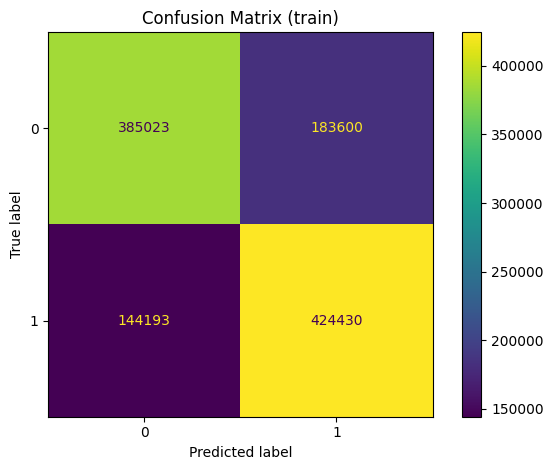

In [5]:
# Randomized search SVM on Steam
print("\nRandomized SVM search on Steam...")
best_steam_model = randomized_svm_search(
    X_train_steam, y_train_steam,
    scoring="f1_macro",
    cv=2,
    n_jobs=10,
    n_iter=20,
    random_state=random_state
)

# Olist Transactions


Randomized SVM search on Olist...
Estimated total time (minutes): 2.54
Range (p20–p80) minutes: 2.03 - 3.17
Fitting 2 folds for each of 20 candidates, totalling 40 fits

Top 5 models:
1. score: 0.669673 | params: {'features__n_components': 200, 'features__gamma': 0.001, 'features__degree': 2, 'features__coef0': 1.0, 'features': Nystroem(coef0=0.0, degree=2, gamma=0.05, kernel='polynomial', n_components=200,
         random_state=42), 'clf__class_weight': 'balanced', 'clf__C': 100.0}
2. score: 0.669352 | params: {'features__n_components': 200, 'features__gamma': 0.001, 'features': Nystroem(gamma=0.05, n_components=200, random_state=42), 'clf__class_weight': 'balanced', 'clf__C': 100.0}
3. score: 0.6653 | params: {'features__n_components': 100, 'features__gamma': 0.001, 'features': Nystroem(gamma=0.05, n_components=200, random_state=42), 'clf__class_weight': 'balanced', 'clf__C': 10.0}
4. score: 0.664526 | params: {'features__n_components': 200, 'features__gamma': 1e-05, 'features': Nys

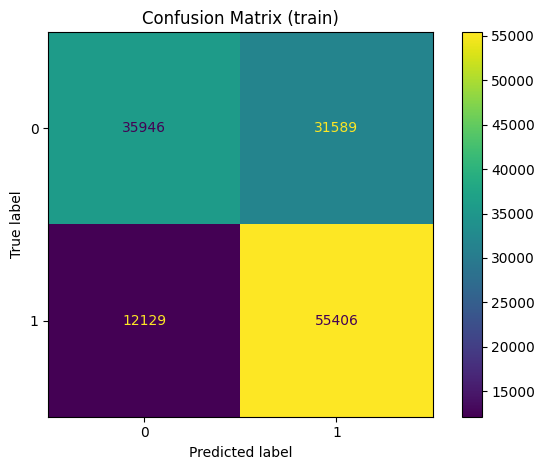

In [6]:
# Randomized search SVM on Olist
print("\nRandomized SVM search on Olist...")
best_olist_model = randomized_svm_search(
    X_train_olist, y_train_olist,
    scoring="f1_macro",
    cv=2,
    n_jobs=10,
    n_iter=20,
    random_state=random_state
)

# Video Game Sales


Randomized SVM search on Video Games Sales...
Estimated total time (minutes): 49.87
Range (p20–p80) minutes: 39.9 - 62.34
Fitting 2 folds for each of 20 candidates, totalling 40 fits

Top 5 models:
1. score: 0.930472 | params: {'features__n_components': 200, 'features__gamma': 0.001, 'features': Nystroem(gamma=0.05, n_components=200, random_state=42), 'clf__class_weight': 'balanced', 'clf__C': 100.0}
2. score: 0.925002 | params: {'features__n_components': 200, 'features__gamma': 0.001, 'features__degree': 2, 'features__coef0': 1.0, 'features': Nystroem(coef0=0.0, degree=2, gamma=0.05, kernel='polynomial', n_components=200,
         random_state=42), 'clf__class_weight': 'balanced', 'clf__C': 100.0}
3. score: 0.918098 | params: {'features__n_components': 200, 'features__gamma': 0.1, 'features__degree': 3, 'features__coef0': 0.0, 'features': Nystroem(coef0=0.0, degree=2, gamma=0.05, kernel='polynomial', n_components=200,
         random_state=42), 'clf__class_weight': None, 'clf__C': 0.

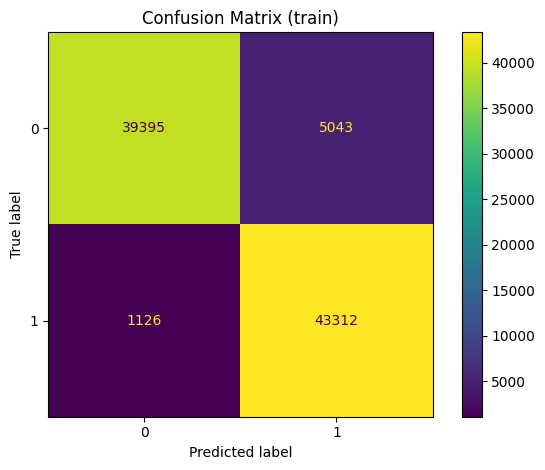

In [7]:
# Randomized search SVM on Video Games Sales
print("\nRandomized SVM search on Video Games Sales...")
best_sales_model = randomized_svm_search(
    X_train_sales, y_train_sales,
    scoring="f1_macro",
    cv=2,
    n_jobs=10,
    n_iter=20,
    random_state=random_state
)